In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import datetime

plt.rcParams["figure.figsize"] = (15, 5)

In [7]:
gpa_threshold_range = (1, 9)
gpa_threshold_interval = 5
gpa_threshold_steps = 3
# => 5, 20, 35

rip_threshold_range = (1, 6)
rip_threshold_interval = 3
rip_threshold_steps = 3
# => 3, 12

In [16]:
gpa_analysis = pd.read_csv("analysis/STREAM_gpa_analysis.csv")
rip_analysis = pd.read_csv("analysis/STREAM_rip_analysis.csv")

In [23]:
gpa = gpa_analysis.iloc[[gpa_threshold_i * gpa_threshold_interval for gpa_threshold_i in range(*gpa_threshold_range, 3)]]
rip = rip_analysis.iloc[[rip_threshold_i * rip_threshold_interval for rip_threshold_i in range(*rip_threshold_range, 3)]]

In [24]:
gpa

,threshold,p,p',n/p ratio,upper limit for train/val accuracy,accuracy'
5,5,59735,13694,59.151888,0.282156,0.019378
20,20,20033,1133,176.380872,0.400314,0.006413
35,35,9770,473,361.662027,0.478632,0.004685


In [25]:
rip

,threshold,p,p',n/p ratio,upper limit for train/val accuracy,accuracy'
3,3,5350,1890,660.455701,0.014883,0.001605
12,12,1438,152,2457.189152,0.021939,0.000516


In [8]:
results = []
for gpa_threshold_i in range(*gpa_threshold_range, 3):
    gpa_threshold = gpa_threshold_i * gpa_threshold_interval

    for rip_threshold_i in range(*rip_threshold_range, 3):
        rip_threshold = rip_threshold_i * rip_threshold_interval
        results.append({
            "version": f"gpa={gpa_threshold}-rip={rip_threshold}", 
            "history": pd.read_csv(f"experiment/version/gpa_threshold={gpa_threshold}-rip_threshold={rip_threshold}/train_history.csv")
            })

In [9]:
results[0]["history"]

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,3.586173e+15,0.0,6.211895e+15,0.0
1,2.161695e+16,0.0,2.272771e+16,0.0
2,5.514178e+16,0.0,4.771554e+16,0.0


In [10]:
train_loss = pd.DataFrame([r["history"]["loss"] for r in results], index=[r["version"] for r in results]).T
train_loss

,gpa=5-rip=3,gpa=5-rip=12,gpa=20-rip=3,gpa=20-rip=12,gpa=35-rip=3,gpa=35-rip=12
0,3.586173e+15,3.677655e+15,4.661742e+14,4.761640e+14,7.805636e+13,8.632765e+13
1,2.161695e+16,2.250061e+16,2.751549e+15,2.799967e+15,4.473390e+14,4.825986e+14
2,5.514178e+16,5.784692e+16,6.898751e+15,7.022602e+15,1.101881e+15,1.188897e+15


In [11]:
val_loss = pd.DataFrame([r["history"]["val_loss"] for r in results], index=[r["version"] for r in results]).T
val_loss

,gpa=5-rip=3,gpa=5-rip=12,gpa=20-rip=3,gpa=20-rip=12,gpa=35-rip=3,gpa=35-rip=12
0,6.211895e+15,6.347218e+15,8.378632e+14,8.586249e+14,1.443316e+14,1.587857e+14
1,2.272771e+16,2.326153e+16,2.944687e+15,2.971518e+15,4.980363e+14,5.378673e+14
2,4.771554e+16,5.058054e+16,6.317864e+15,6.426966e+15,1.033196e+15,1.120033e+15


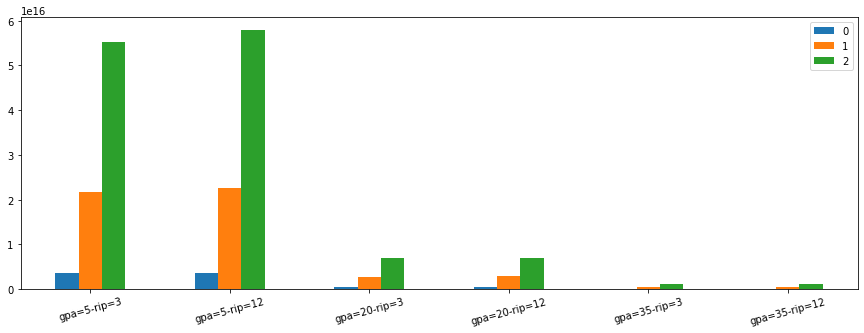

In [12]:
train_loss.T.plot(kind="bar", rot=0)    # rot for rotating xlabel

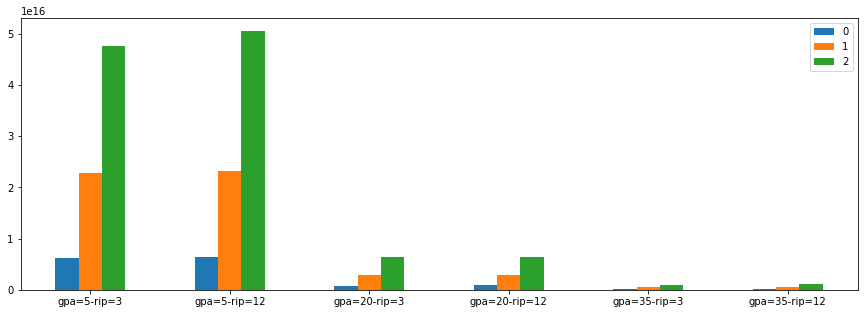

In [15]:
val_loss.T.plot(kind="bar", rot=0)    # rot for rotating xlabel

In [50]:
# Weight for variable significance to the model
# Grater the weight, more the variable impacts the model.
# NOTE : Weights are roughly estimated, not calculated
W_g = 0.9
W_r = 0.1

## Estimate of Masked Accuracy (= Accuracy with upper limit)
total_acc = acc \* (1 - (upper_limit_gpa\*W_g + upper_limit_rip\*W_r))  
acc ∝ 1/loss

Then,  
total_acc ∝ 1/loss \* (1 - (upper_limit_gpa\*W_g + upper_limit_rip\*W_r))

In [102]:
acc_estimate = []
for i in range(3):
    for j in range(2):
        acc_estimate.append((1 - (gpa.iloc[i]["upper limit for train/val accuracy"]*W_g + rip.iloc[j]["upper limit for train/val accuracy"]*W_r)) * 1/train_loss.iloc[:, i*2+j])   #train_loss["gpa=5-rip=3"]
acc_estimate = pd.DataFrame(acc_estimate).T

In [103]:
acc_estimate

,gpa=5-rip=3,gpa=5-rip=12,gpa=20-rip=3,gpa=20-rip=12,gpa=35-rip=3,gpa=35-rip=12
0,2.076227e-16,2.022662e-16,1.369078e-15,1.338874e-15,7.273495e-15,6.568428e-15
1,3.444386e-17,3.305979e-17,2.319526e-16,2.276896e-16,1.269155e-15,1.174966e-15
2,1.350285e-17,1.285920e-17,9.251370e-17,9.078165e-17,5.152485e-16,4.769438e-16


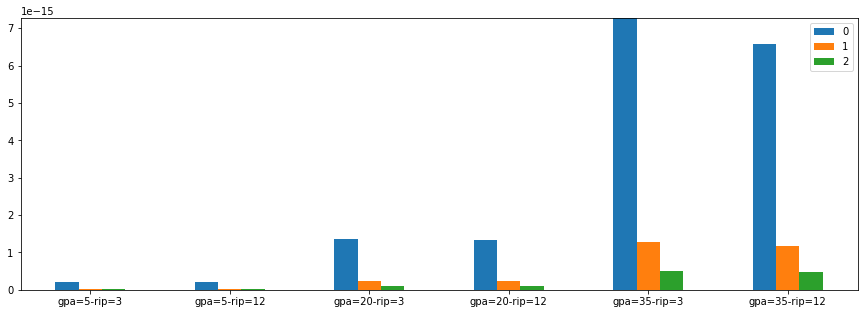

In [104]:
acc_estimate.T.plot(kind="bar", rot=0)

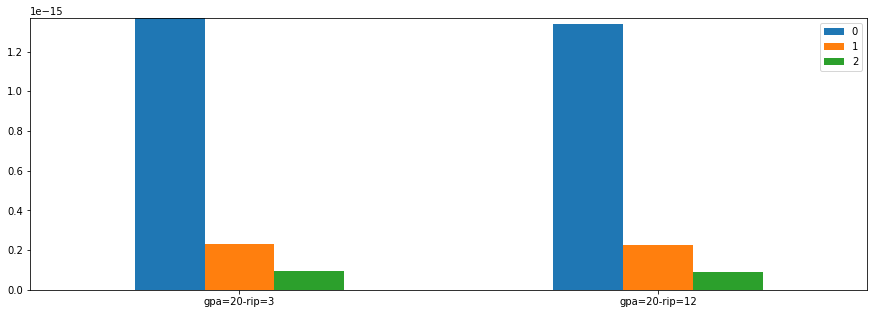

In [106]:
acc_estimate.T.iloc[2:4].plot(kind="bar", rot=0)

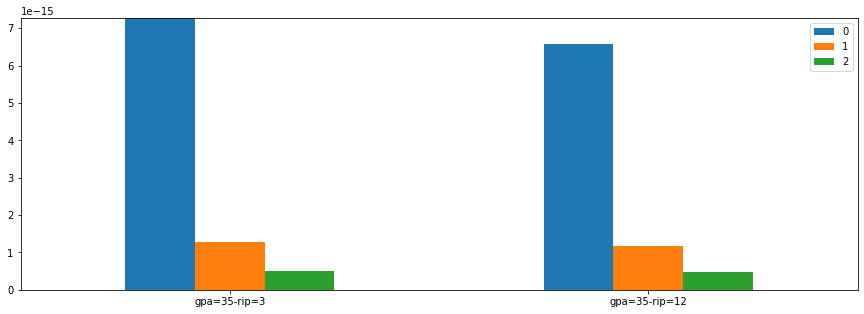

In [105]:
acc_estimate.T.iloc[-2:].plot(kind="bar", rot=0)

## Conclusion

Set the Maximum upper_limit to 0.5.  

### GPA  
Greater the GPA threshold, more the total_accuracy increases.  
Within the Maximum upper_limit, 